In [4]:
import hashlib
import random
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class LinearNet(nn.Module):
    """Small Linear Network for MNIST."""

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc_weights = nn.ParameterList([nn.Parameter(torch.empty(1)) for weight in range(784)])
        init_fc = [nn.init.uniform_(x) for x in self.fc_weights]
        
        self.fc_bias = nn.Parameter(torch.empty(1))
        nn.init.uniform_(self.fc_bias)
        
    #def __init__(self):
    #    super(LinearNet, self).__init__()
    #    self.fc = nn.Linear(28*28, 1)
    #    nn.init.normal(self.fc.weight)

    #def forward(self, x):
    #    x = self.fc(x)
    #    return x
    
    def forward(self, x):
        #fc_layer = torch.cat(tuple(self.fc_weights)).unsqueeze(0)
        #x = x @ fc_layer.T + self.fc_bias
        for i, param in enumerate(self.fc_weights):
            if i==0:
                p=x[:,i]*param
            else:
                p += x[:,i]*param
        x = p.unsqueeze(1) + self.fc_bias
        return x
    def get_weights(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}


In [182]:
import hashlib
import random
import os

class ConsistentHash():
    def __init__(self, keys_to_hash, nodes, hashes_per_node=1):
        self.keys_to_hash = keys_to_hash
        self.nodes = nodes
        self.hashes_per_node = hashes_per_node
        self.node_hashes = {}
        self.node_tuples = []
        self.hash_assignments = {}
        self.node_assignments = {}
        for node in nodes:
            self.add_node(node)
        for key in keys_to_hash:
            self.add_key(key)
    def get_hash_key(self, key):
        #Gets the hash for a key
        return hashlib.sha256(str(key).encode()).hexdigest()
    def get_hash_node(self, node):
        #Gets multiple hashes for a node in a deterministic manner
        return [hashlib.sha256((str(node) + str(hash_iter)).encode()).hexdigest() for hash_iter in range(self.hashes_per_node)]
    def assign_to_node(self, key):
        #Assigns a key to the correct node
        key_hash = self.hash_assignments[key]
        self.node_assignments[key] = self.node_tuples[0][1]
        for h, node in self.node_tuples:
            if h > key_hash:
                self.node_assignments[key] = node
                break
    def reassign_keys(self):
        #Reassigns keys when a node has been added or deleted
        self.node_tuples = sorted([x for x in self.node_tuples if x[1] in self.node_hashes], key=lambda x: x[0])
        for key in self.node_assignments: #Won't do anything if no node added yet
            self.assign_to_node(key)        
    def add_key(self, key):
        #Adds a key
        self.hash_assignments[key] = self.get_hash_key(key)
        self.assign_to_node(key)
    def delete_key(self, key):
        #Deletes a key
        del self.hash_assignments[key]
        del self.node_assignments[key]
    def add_node(self, node):
        #Adds a node
        hashes = self.get_hash_node(node)
        self.node_hashes[node] = hashes
        self.node_tuples.extend([(h, node) for h in hashes])
        self.reassign_keys()
    def delete_node(self, node):
        #Deletes a node
        del self.node_hashes[node]
        self.nodes.remove(node)
        self.reassign_keys()
    def delete_node_and_reassign_to_others(self, node):
        keys_to_reassign = self.get_keys_per_node()[node]
        del self.node_hashes[node]
        self.nodes.remove(node)
        self.node_tuples = [x for x in self.node_tuples if x[1] in self.node_hashes]
        for key in keys_to_reassign:
            self.delete_key(key)
            self.add_key(key)
    def get_key_to_node_map(self):
        #Returns dictionary of key -> node mappings
        return self.node_assignments
    def get_keys_per_node(self):
        #Returns map from node to all keys it covers
        map_dict = {node : [] for node in self.nodes}
        for key in self.node_assignments:
            map_dict[self.node_assignments[key]].append(key)
        return map_dict


In [183]:
chash = ConsistentHash(list(range(50)), ["server1", "server2", "server3"], 10)

In [133]:
hashlib.md5(str(10).encode()).hexdigest()

'd3d9446802a44259755d38e6d163e820'

In [186]:
chash.get_keys_per_node()

{'server1': [6,
  8,
  9,
  13,
  15,
  28,
  29,
  32,
  33,
  34,
  39,
  41,
  46,
  47,
  49,
  1,
  3,
  4,
  7,
  10,
  11,
  12,
  14,
  17,
  18,
  21,
  22,
  23,
  36,
  37,
  42,
  43,
  44,
  45],
 'server2': [2, 16, 19, 20, 24, 25, 31, 35, 38, 40, 48, 0, 5, 26, 27, 30]}

In [185]:
chash.delete_node_and_reassign_to_others("server3")

In [129]:
chash.node_hashes, chash.hash_assignments

({'server1': ['cf79a04532fe5a9191733474b6d5836abf784acf91adc64f2dfd9387949d9e70',
   'b60321ad62fbb34b0e14dd0f47a2d05411f49eb390bddacb0b63d34d67a1b8f9',
   'c4b8645477b3ea294c778fe1633c2a3d318fe39fe702a542b3fd0c8760512022',
   '1342ad1326b755faa8cdfcb9d83bc28af6ac86ba030f0ba423c25a10cd9316a0',
   '05f81e5412234bbbe7eb8906b9b50c118be16c9172f90bb0c2e904f75c0d292f'],
  'server2': ['dfbeba9fcc2e4a8cc6db93d5a50afbe1c7d6fb6b9e38c4ba29ac270d3200ed02',
   'c35049c8bf839f394802b751c0028149c207efb6c810552017daa5fdc87fd7aa',
   'db32aeeb7fb6064b370d5bbe9d0f5eedea0c6bb5814b04a686b6d58757aa6aa1',
   'fd52a2ede464752ed69161a85f150916ba68a9a173177a3f6c558febe624ce5b',
   'b79ad9c68b681e9658ba8a6efb74014efeffd0ce5c36c82555fbeec472066b07']},
 {0: '5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9',
  1: '6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b',
  2: 'd4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35',
  3: '4e07408562bedb8b60ce05c1decfe3ad16b72230

In [11]:
def get_max_mean_load(keys_per_node):
    loads = [len(v) for k,v in keys_per_node.items()]
    return sum(loads) / len(loads) / max(loads)

In [36]:
chash = ConsistentHash(list(range(50)), ["serv1", "serv2", "serv3", "serv4"], 5)

In [160]:
lnet = LinearNet()
key_values = lnet.get_weights()
keys = np.array(list(key_values.keys()))
server_ids = ["server" + str(ind) for ind in range(5)]


In [153]:
{k:len(x) for k,x in chash.get_keys_per_node().items()}

{'serv1': 208, 'serv2': 183, 'serv3': 198, 'serv4': 196}

In [171]:
hashes_hpn = {}
maxmeans_hpn = {}
for hpn in [1, 5, 10, 50, 100]:
    loads = []
    for run in range(20):
        currhash = ConsistentHash(np.random.uniform(size=len(keys)), server_ids, hpn).get_keys_per_node()
        loads.append(get_max_mean_load(currhash))
    maxmeans_hpn[hpn] = sum(loads) / len(loads)

In [172]:
hpns_to_try = [1, 5, 10, 50, 100]
params_to_try = [10, 50, 100, 500, 1000, 5000, 10000]
hashes_par = {x:[] for x in hpns_to_try}
for hpn in hpns_to_try:
    loads = []
    for params in params_to_try:
        for run in range(20):
            curr_hash = ConsistentHash(np.random.uniform(size=params), server_ids, hpn)
            loads.append(get_max_mean_load(curr_hash.get_keys_per_node()))
        hashes_par[hpn].append(sum(loads) / len(loads))

In [164]:
maxmeans_par

{10: 0.4166666666666667,
 50: 0.5681818181818182,
 100: 0.6944444444444444,
 200: 0.6944444444444444,
 500: 0.7530120481927711,
 1000: 0.7763975155279503,
 2000: 0.8169934640522876}

/users/patelas/anaconda3/envs/ParamServer/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Average Mean Load / Max Load')

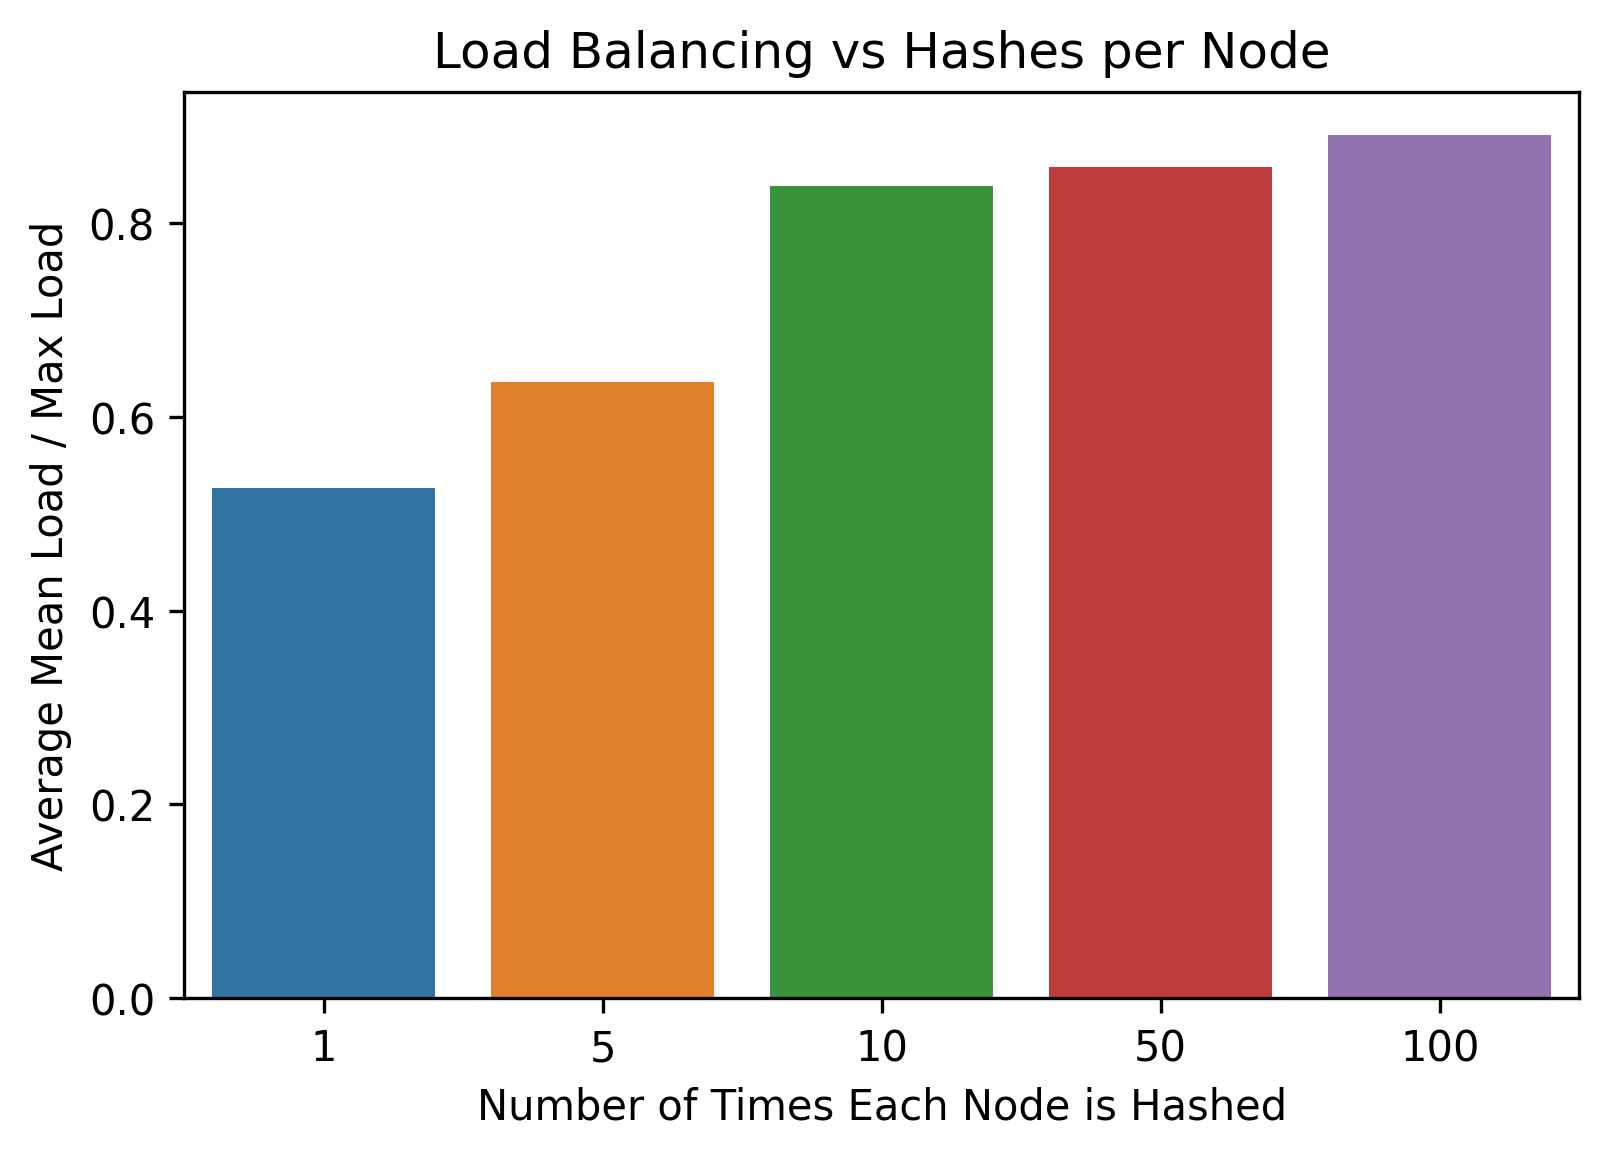

In [173]:
plt.figure(dpi=300)
sns.barplot(list(maxmeans_hpn.keys()), list(maxmeans_hpn.values()))
plt.title("Load Balancing vs Hashes per Node")
plt.xlabel("Number of Times Each Node is Hashed")
plt.ylabel("Average Mean Load / Max Load")

/users/patelas/anaconda3/envs/ParamServer/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/users/patelas/anaconda3/envs/ParamServer/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/users/patelas/anaconda3/envs/ParamServer/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

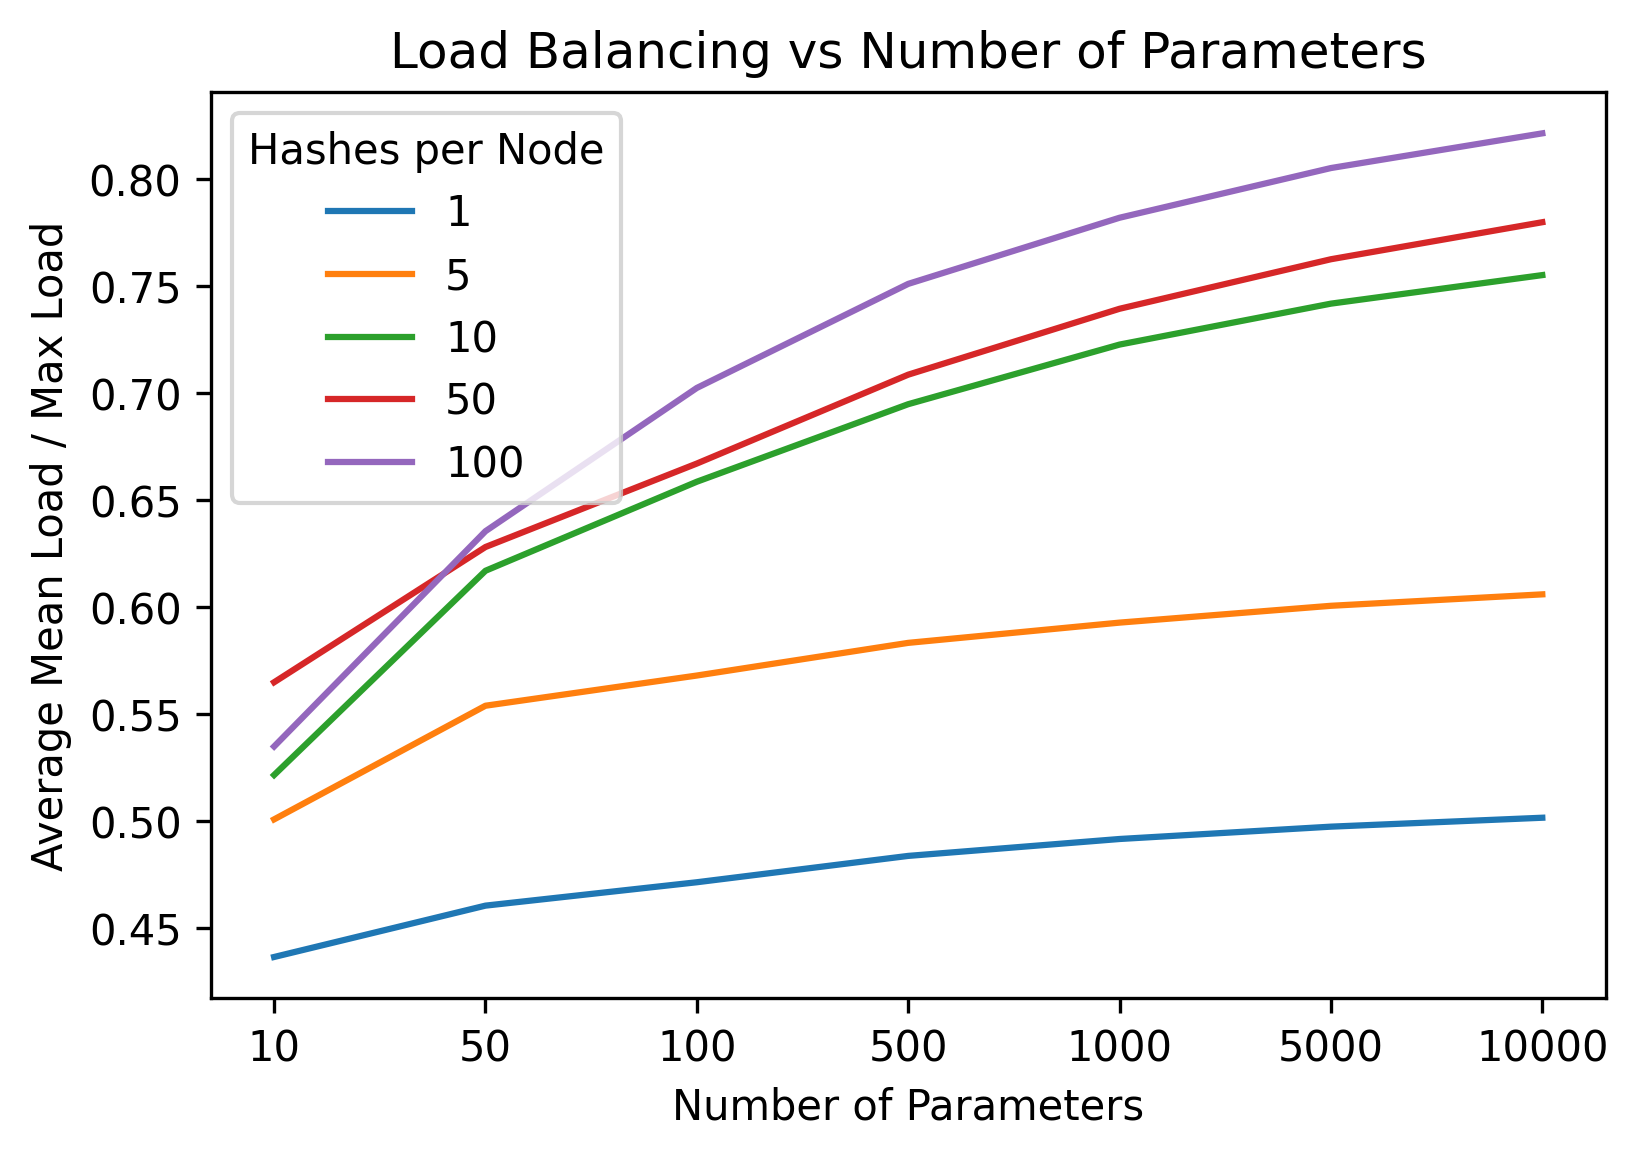

In [174]:
plt.figure(dpi=300)
# sns.barplot(list(maxmeans_par.keys()), list(maxmeans_par.values()))
for h in hashes_par:
    sns.lineplot([str(x) for x in params_to_try], hashes_par[h], label=h)
plt.title("Load Balancing vs Number of Parameters")
plt.xlabel("Number of Parameters")
plt.ylabel("Average Mean Load / Max Load")
plt.legend(title="Hashes per Node")

In [56]:
hashes_par

{1: [0.4375,
  0.40355445906432746,
  0.4028344343404873,
  0.40601828035625775,
  0.40880849607439484,
  0.40943064798495743,
  0.41000190151793425],
 5: [0.30833333333333335,
  0.43740773115773124,
  0.4901982276982277,
  0.5389268063644139,
  0.5677980348470697,
  0.588810767575261,
  0.6042715781618986],
 10: [0.39583333333333337,
  0.5064484126984128,
  0.5398252575884155,
  0.5710633679936369,
  0.5974691877752859,
  0.6210269681964419,
  0.6385960749569716],
 50: [0.37500000000000006,
  0.5042613636363636,
  0.5564901465636761,
  0.6217150322579842,
  0.6613271639229376,
  0.6913945740357115,
  0.7160642110366621],
 100: [0.5208333333333334,
  0.5684367715617716,
  0.5998718379716832,
  0.6453155060132157,
  0.6699161946771794,
  0.693402958475063,
  0.7120894223472514]}